# Tutorial 11: Beyond two-group comparisons

In [1]:
library(tidyverse)
library(infer)
library(datateachr)
library(testthat)
library(digest)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘infer’ was built under R version 4.0.2”

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘broom’ was b

## Learning Objectives

- Run a simple one-way ANOVA, without knowing the details of the test (the level of detail required is what's presented in the blog post).
- Apply FDR or Bonferroni correction to control the errors when performing multiple hypothesis testing.
- The value of presenting an entire distribution as a prediction.

## Exercise 1: Multiple Comparisons

Last week, we saw that we're more likely to commit a Type I error as we test more and more hypotheses. This week, we'll investigate two methods for addressing this issue. 

Consider the GWAS dataset:

In [2]:
gwas <- 
    read_csv("gwas.csv")  %>% 
    rename(p_value = `p-value`)

head(gwas)

Parsed with column specification:
cols(
  public_gene_name = col_character(),
  `p-value` = col_double()
)



public_gene_name,p_value
<chr>,<dbl>
osm-1,0.000001020
che-3,0.000016100
F01D4.9,0.000055600
mdf-1,0.000100000
cnt-1,0.000123946
lars-1,0.001526370


The dataset, as described by Dr. Tiffany Timbers:

> The dataset you will see contains two columns, a list of gene names and a list of unadjusted p-values generated from the analysis (the particular statistical test used is called the Sequence Kernel Analysis test, or SKAT). These p-values were created by repeating the analysis on many variables from the same dataset, thus we have a multiple testing problem to deal with!
> 
> Each p-value corresponds to a gene, and tests whether that gene is associated to a phenotype.
> 
> The study can be accessed here: http://dx.doi.org/10.1371/journal.pgen.1006235

In STAT 201, we will very briefly explore two methods for handling multiple hypothesis testing: the __Bonferroni__ and __Benjamin-Hochberg (BH)__ adjustments. Unfortunately, we will not have time to go into how they work. But, the idea for both of them is to increase the p-values so that tests are less likely to pass.

In general, it's not always obvious when you should use a p-value adjustment. If you conduct a study that includes a few unrelated hypothesis tests, should you "proof" the entire study by adjusting all p-values? Probably not. If you do, and you decide to gain a little bit of extra insight by testing one last hypothesis before submitting the study, should you then adjust all of the p-values in the study, potentially changing your results? This isn't realistic. But, if you can group your hypotheses into one overarching question, like [testing to see which of 20 types of jellybeans cause acne](https://xkcd.com/882/), you then might want to implement some level of error-proofing.

### Question 1.1

How many of the null hypotheses would be rejected under a 0.05 significance level? Store this value in a variable named `number_significant`. What proportion of the total number of tests is that? Store this value in a variable named `prop_significant`.

In [3]:
# number_significant <- FILL_THIS_IN
# prop_significant <- FILL_THIS_IN

### BEGIN SOLUTION
number_significant <- 
    gwas %>% 
    filter(p_value < 0.05) %>% 
    nrow()

prop_significant <- gwas %>% 
    summarise(prop = mean(p_value < 0.05)) %>% 
    pull(prop)
### END SOLUTION

print(number_significant)
print(prop_significant)

[1] 100
[1] 0.08695652


In [4]:
test_that("Amount significant", {
  expect_identical(
    digest(as.numeric(number_significant)),
    "d344558826c683dbadec305ed64365f1"
  )
  expect_identical(
    digest(round(prop_significant, digits = 4)),
    "99b9d16651e54de85f1fccc55493a06e"
  )
})
cat("success!")

success!

### Question 1.2: Bonferroni Adjustment

The Bonferroni correction is seen as an aggressive p-value adjustment method. So, it typically won't be able to detect subtle effect sizes. It limits the probability of seeing at least one false positive (Type I error) to the specified significance level $\alpha$. 

The idea is, if there are $k$ hypotheses being tested, to either (1) adjust your chosen significance level $\alpha$ to $\alpha / k$, or equivalently, (2) multiply your p-values by $k$.

Adjust the p-values of the GWAS study according to a Bonferroni adjustment. Store the adjusted p-values in a vector named `pval_bonf`. You can use the `p.adjust()` function, inserting the vector of p-values in the first argument. How many of these null hypotheses are rejected now, under a 0.05 significance level? Put the number in a variable named `count_bonf`.

In [5]:
# pval_bonf <- p.adjust(FILL_THIS_IN, method = "bonferroni")
# count_bonf <- FILL_THIS_IN

### BEGIN SOLUTION
pval_bonf <- p.adjust(gwas$p_value, method = "bonferroni")
count_bonf <- sum(pval_bonf < 0.05)
### END SOLUTION

head(pval_bonf)
print(count_bonf)

[1] 0.0011730 0.0185150 0.0639400 0.1150000 0.1425379 1.0000000

[1] 2


In [6]:
test_that("Amount significant", {
  expect_identical(
    digest(signif(sort(pval_bonf), digits = 4)),
    "2a8b9d0aa1b0678a4ba67a6799b630ec"
  )
  expect_identical(
    digest(as.numeric(count_bonf)),
    "db8e490a925a60e62212cefc7674ca02"
  )
})
cat("success!")

success!

### Question 1.3: BH Adjustment

The BH method is a more forgiving method in comparison to the Bonferroni method, and so may be more realistic. Instead of assigning a probability for seeing any Type I error at all, the BH method limits the _false discovery rate_ = the proportion of "discoveries" (rejections of the null) that are false. 

Adjusting the p-values to limit the false discovery rate to some specified level $\alpha$ is more complicated, and we won't get into details (and won't expect you to, either). But the idea is that, given that p-values are completely random numbers between 0 and 1 _if the null hypothesis is true_, the collection of p-values are compared against what a random sample between 0 and 1 would look like. The p-values that deviate from this pattern are flagged as being significant.

Adjust the p-values of the GWAS study according to a BH adjustment. Store the adjusted p-values in a vector named `pval_bh`. How many of these null hypotheses are rejected now, under a 0.05 significance level? Put the number in a variable named `count_bh`.

In [7]:
# pval_bh <- p.adjust(FILL_THIS_IN, method = "BH")
# count_bh <- FILL_THIS_IN

### BEGIN SOLUTION
pval_bh <- p.adjust(gwas$p_value, method = "BH")
count_bh <- sum(pval_bh < 0.05)
### END SOLUTION

head(pval_bh)
print(count_bh)

[1] 0.00117300 0.00925750 0.02131333 0.02850758 0.02850758 0.25812641

[1] 5


In [8]:
test_that("Amount significant", {
  expect_identical(
    digest(signif(sort(pval_bh), digits = 4)),
    "40cdfc2e1720e67f3aae56823ec9ed9e"
  )
  expect_identical(
    digest(as.numeric(count_bh)),
    "5e338704a8e069ebd8b38ca71991cf94"
  )
})
cat("success!")

success!

## Exercise 2: Prediction

Until now, we've been making inference on _population parameters_, such as means, quantiles, variances, etc. As we've seen, this inference allows us to present both (1) our best guess as to what the parameter is (an estimate), along with (2) a description of uncertainty (such as confidence intervals and hypothesis tests). But, 
how can we go about making inference on a _new observation_? 

In the worksheet, you explored the inference part of predictions. In this tutorial, you'll explore the predictions themselves.

Consider the survey data stored in `attitude`, used in the worksheet. How can we predict what the survey results would be in another department that wasn't included in the survey? Recall that each row of the dataset corresponds to a department that was surveyed.

In [9]:
head(attitude)

,rating,complaints,privileges,learning,raises,critical,advance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,43,51,30,39,61,92,45
2,63,64,51,54,63,73,47
3,71,70,68,69,76,86,48
4,61,63,45,47,54,84,35
5,81,78,56,66,71,83,47
6,43,55,49,44,54,49,34


As an aside:

- This prediction question is what the branch of _supervised learning_ is primarily concerned with. Usually, it's most useful to make predictions when more than one _predictor_ variable is present (for now, we only have one predictor variable: "question"). But, without first thinking about how to make predictions in the absence of predictor variables (or at least, in the presence of one grouping variable like we have), it's easy to lose sight of the interpretation of these predictions. (Hint: the interpretation of a prediction is _not_ just "a best guess".)
- It's worth saying that, if you were working for this organization that was surveyed, you might have anecdotal evidence as to how this department might respond to the survey. Sometimes, in the presence of numeric analyses, it's easy to forget this and to only rely on the numbers, but human input is also very valuable.

### Question 2.1

Probably the most common approach to prediction is to use the mean. What would the prediction be for the `"raises"` question in this case? Store your prediction in a variable named `prediction_raises`. Yes, this just amounts to calculating the mean!

(By the way, it seems most supervised learning models try to make predictions using the mean, although there's nothing about the mean that makes it any better of a prediction than other parameters such as the median!) 

In [10]:
# prediction_raises <- FILL_THIS_IN

### BEGIN SOLUTION
prediction_raises <- 
    attitude %>% 
    pull(raises) %>% 
    mean()
### END SOLUTION

print(prediction_raises)

[1] 64.63333


In [11]:
test_that("Mean prediction of Raises", {
  expect_identical(
    digest(round(prediction_raises, digits = 4)),
    "dd346a8cabe03648836f07864372d5f5"
  )
})
cat("success!")

success!

### Question 2.2

What score would you predict the department to give on the `"privileges"` question? This time, use the median as a prediction, using the `median()` function. Store your prediction in the variable `prediction_privileges`.

In [12]:
# prediction_privileges <- FILL_THIS_IN

### BEGIN SOLUTION
prediction_privileges <- 
    attitude %>% 
    pull(privileges) %>% 
    median()
### END SOLUTION

print(prediction_privileges)

[1] 51.5


In [13]:
test_that("Median prediction of Privileges", {
  expect_identical(
    digest(round(prediction_privileges, digits = 1)),
    "8e53beb1022c46a17cdfe1f1f2f2f827"
  )
})
cat("success!")

success!

### Question 2.3

Depending on the application, you should ask yourself if you truly need a single value prediction. Consider predicting the department's response to the `"critical"` question based on the histogram of outcomes below:

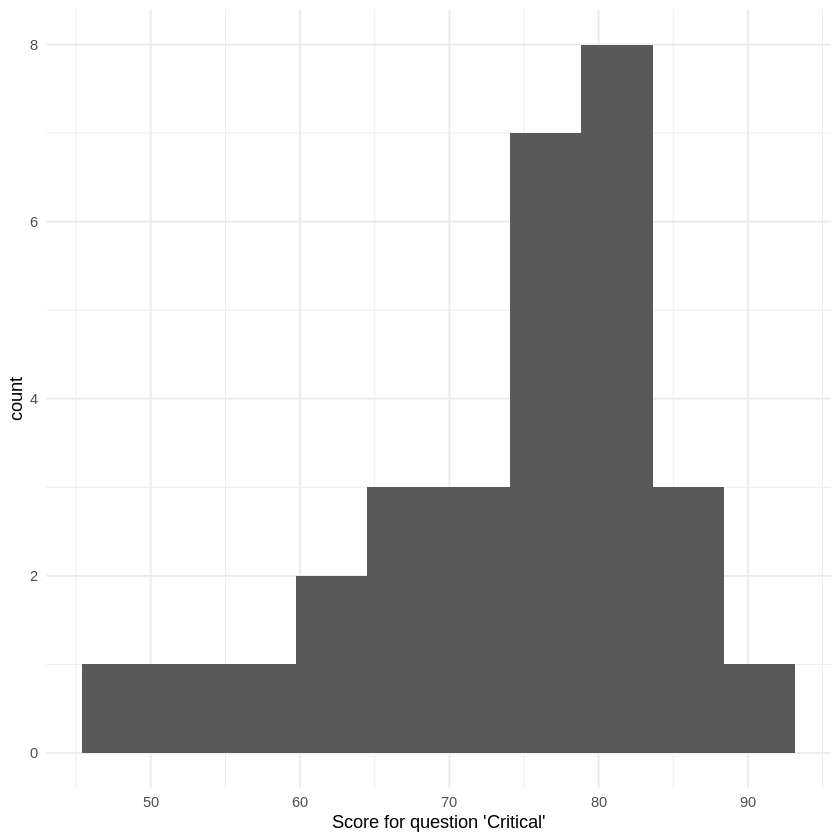

In [14]:
ggplot(attitude, aes(critical)) +
    geom_histogram(bins = 10) +
    theme_minimal() +
    xlab("Score for question 'Critical'")

Which of these statements can be inferred by looking at the histogram? Store the letter to your response in a variable named `prediction_critical`.

**a**\. Probably won't be less than 50   
**b**\. Probably won't be more than 90   
**c**\. Most likely to be somewhere between 65 and 85   
**d**\. All of the above

By the way, we're able to come up with this histogram, because we have access to multiple observations for the `"critical"` question. In supervised learning scenarios, it's uncommon to have such luxury. Yet, methods exist to access such a distribution -- but that's beyond the scope of this course. 

In [15]:
# prediction_critical <- "FILL_THIS_IN"

### BEGIN SOLUTION
prediction_critical <- "d"
### END SOLUTION

In [16]:
test_that("Prediction Critical is right", {
  answer_hash <- digest(tolower(prediction_critical))
  expect_identical(answer_hash, "d110f00cfb1b248e835137025804a23b")
})
cat("success!")

success!

### Question 2.4

Ultimately, predictions are useful because they help us make decisions. If you have to make many decisions quickly, it may not be practical to have a human look at a histogram as part of a decision-making procedure. But if there are few decisions that are very important, going beyond a single-value prediction is useful, such as by looking at histograms. 

Given this, which of the following scenarios **would it be desirable** to investigate histogram(s) before making decisions? Don't worry about how you'd come up with such histograms, or what they'd look like. Put your choices in a single variable named `prediction_decisions`, in alphabetical order. 

**a**\. You are deciding between two people to hire in a high-leverage position in your company, and you want to predict what the "productivity" of each person would be after they are hired.    
**b**\. You work for a song streaming company, and want to predict favourable songs for each of your customers automatically.    
**c**\. You are trying to decide whether your business can afford a large purchase.     
**d**\. You work for the Coast Mountain Bus Company, who operates all the city busses in the Vancouver area, and want to predict the demand at every bus stop throughout this coming Canada Day. 

In [17]:
# prediction_decisions <- "FILL_THIS_IN"

### BEGIN SOLUTION
prediction_decisions <- "ac"
### END SOLUTION

In [18]:
test_that("Prediction decisions is/are right", {
  answer_hash <- digest(tolower(prediction_decisions))
  expect_identical(answer_hash, "7ecaefcc6ebc9848e7cb04b5c783ae0a")
})
cat("success!")

success!

## Exercise 3: ANOVA

In this exercise, we will revisit the `attitude` survey data from the worksheet. We are going to investigate whether there's a significant difference between the means of two specific questions: "privileges" and "learning". The following tibble contains the relevant subset of data. 

In [19]:
attitude_tidy <- 
    attitude %>% 
    select(-rating) %>% 
    pivot_longer(everything(), names_to = "question", values_to = "score")

attitude_two <- 
    attitude_tidy %>% 
   filter(question %in% c("privileges", "learning"))

head(attitude_two)

question,score
<chr>,<dbl>
privileges,30
learning,39
privileges,51
learning,54
privileges,68
learning,69


### Question 3.1

Test the hypothesis using a two-sample t-test, approximating the group variances to be equal. Use the `tidy()` function from the broom package to tidy your results, putting the resulting tibble in a variable called `two_t_equal_tidy`.

In [20]:
# two_t_equal_tidy <- 
#    t.test(FILL_THIS_IN ~ FILL_THIS_IN, data = attitude_two, 
#               var.equal = FILL_THIS_IN) %>% 
#   tidy()

### BEGIN SOLUTION
two_t_equal_tidy <- 
    t.test(score ~ question, data = attitude_two, 
               var.equal = TRUE) %>% 
    tidy()
### END SOLUTION

print(two_t_equal_tidy)

# A tibble: 1 x 10
  estimate estimate1 estimate2 statistic p.value parameter conf.low conf.high
     <dbl>     <dbl>     <dbl>     <dbl>   <dbl>     <dbl>    <dbl>     <dbl>
1     3.23      56.4      53.1      1.04   0.301        58    -2.96      9.43
# … with 2 more variables: method <chr>, alternative <chr>


In [21]:
test_that("two-sample t test", {
  unclassed_tibble <- two_t_equal_tidy %>% 
    mutate(across(where(is.numeric), signif, digits = 6)) %>% 
    unclass()
  expect_identical(digest(unclassed_tibble), "c326804de16a7881dac2a5b3c33ca020")
})
cat("success!")

success!

### Question 3.2

Test the hypothesis using a two-sample t-test, allowing the group variances to be unequal. Use the `tidy()` function from the broom package to tidy your results, putting the resulting tibble in a variable called `two_t_unequal_tidy`.

In [22]:
# two_t_unequal_tidy <- t.test(FILL_THIS_IN ~ FILL_THIS_IN, data = attitude_two, 
#                              var.equal = FILL_THIS_IN) %>% 
#   tidy()

### BEGIN SOLUTION
two_t_unequal_tidy <- 
    t.test(score ~ question, data = attitude_two, 
               var.equal = FALSE) %>% 
    tidy()
### END SOLUTION

print(two_t_unequal_tidy)

# A tibble: 1 x 10
  estimate estimate1 estimate2 statistic p.value parameter conf.low conf.high
     <dbl>     <dbl>     <dbl>     <dbl>   <dbl>     <dbl>    <dbl>     <dbl>
1     3.23      56.4      53.1      1.04   0.301      57.9    -2.96      9.43
# … with 2 more variables: method <chr>, alternative <chr>


In [23]:
test_that("two-sample t test, unequal", {
  unclassed_tibble <- two_t_unequal_tidy %>% 
    mutate(across(where(is.numeric), signif, digits = 6)) %>% 
    unclass()
  expect_identical(digest(unclassed_tibble), "fa84d26bab7f0c530f9128ddcbe0d5d6")
})
cat("success!")

success!

### Question 3.3

Test the hypothesis using an ANOVA F-test. Use the `tidy()` function from the broom package to tidy your results, putting the resulting tibble in a variable called `two_anova_tidy`. Hint: use the `aov()` function. Scaffolding is given in the worksheet if you need a reminder. 

In [24]:
# two_anova_tidy <- FILL_THIS_IN
### BEGIN SOLUTION
two_anova_tidy <- 
    aov(score ~ question, data = attitude_two) %>% 
    tidy()
### END SOLUTION

print(two_anova_tidy)

# A tibble: 2 x 6
  term         df sumsq meansq statistic p.value
  <chr>     <dbl> <dbl>  <dbl>     <dbl>   <dbl>
1 question      1  157.   157.      1.09   0.301
2 Residuals    58 8336.   144.     NA     NA    


In [25]:
test_that("two-sample t test, unequal", {
  unclassed_tibble <- two_anova_tidy %>% 
    mutate(across(where(is.numeric), signif, digits = 6)) %>% 
    unclass()
  expect_identical(digest(unclassed_tibble), "d930a51f72a40a3933ae536c699a924a")
})
cat("success!")

success!

### Question 3.4

Store the $p$-values of the above three tests in the following variables. 

- Two-sample $t$-test, equal variance: `two_t_equal`
- Two-sample $t$-test, unequal variance: `two_t_unequal`
- ANOVA $F$-test: `two_anova`

By the way, the ANOVA $F$-test has a $p$-value that's identical to one of the two $t$-tests (take a look at which one) -- this is no accident, this is always true whenever there are two groups! So, the ANOVA $F$-test is truly a generalization of the two-sample $t$-test. 

In [26]:
# two_t_equal <- FILL_THIS_IN
# two_t_unequal <- FILL_THIS_IN
# two_anova <- FILL_THIS_IN

### BEGIN SOLUTION
two_t_equal <- two_t_equal_tidy$p.value
two_t_unequal <- two_t_unequal_tidy$p.value
two_anova <- two_anova_tidy$p.value[1]
### END SOLUTION

print(two_t_equal)
print(two_t_unequal)
print(two_anova)

[1] 0.3005753
[1] 0.3005827
[1] 0.3005753


In [27]:
test_that("Two group test", {
  expect_identical(
    digest(round(two_t_equal, digits = 6)), 
    "77710c78ca705287d335be9ac2ca8d86"
  )
  expect_identical(
    digest(round(two_t_unequal, digits = 6)), 
    "5e8f21b565d74ce485c5852857bf2786"
  )
  expect_identical(
    digest(round(two_anova, digits = 6)), 
    "77710c78ca705287d335be9ac2ca8d86"
  )
})
cat("success!")

success!

### Question 3.5

In the above two-sample comparison, the two questions that appeared to have the most similar means were selected for comparison. Why is this bad practice? Store the letter of your choice in the variable named `why_inappropriate`.

**a**\.  If we want to highlight two groups, we should choose the ones that are most _different_, not the most similar.    
**b**\.  This is an example of "cherry picking": only presenting two groups that appear the most similar means that these two groups are more likely to be artificially similar.     
**c**\.  This is actually not bad practice at all -- it's a natural next step after ANOVA to investigate pairs of groups. 


In [28]:
# why_inappropriate <- "FILL_THIS_IN"

### BEGIN SOLUTION
why_inappropriate <- "b"
### END SOLUTION

print(why_inappropriate)

[1] "b"


In [29]:
test_that("Answer to why these two groups", {
  answer_hash <- digest(tolower(why_inappropriate))
  if (answer_hash == "127a2ec00989b9f7faf671ed470be7f8") {
    cat("This response suggests that there's some statistical",
        "justification for choosing two specific groups to test,", 
        "but there is no such justification.")
  } else if (answer_hash == "6e7a8c1c098e8817e3df3fd1b21149d1") {
    cat("Although this is true, the comparison we did only includes",
        "one specific pair of groups, whereas we should have",
        "investigated all pairs")
  }
  expect_identical(answer_hash, "ddf100612805359cd81fdc5ce3b9fbba")
})
cat("success!")

success!